In [98]:
import os
import tarfile
import datetime
import random

import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns 

from statistics import mean
from sklearn.metrics import jaccard_score

from tqdm.auto import tqdm, trange

## Data loading and preprocessing 

Slightly modified version of milestone 2 submission.

Logic stays the same, modifications target mostly clarity/performance/my subjective sense of beauty of the code.

Important changes:

<ol>
  <li>I changed column names to only *lower case*</li>
</ol> 

In [99]:
DATA_FOLDER = 'data'
DB_FOLDER_NAME = 'MovieSummaries'
MOVIE_TABLE_PATH = os.path.join(DATA_FOLDER, DB_FOLDER_NAME, 'movie.metadata.tsv')
CHARACTER_TABLE_PATH = os.path.join(DATA_FOLDER, DB_FOLDER_NAME, 'character.metadata.tsv')

movies_columns = ['wikipedia movie id',
                  'freebase movie id',
                  'movie name',
                  'movie release date',
                  'movie box office revenue',
                  'movie runtime',
                  'movie languages',
                  'movie countries',
                  'movie genres']

characters_columns = ['wikipedia movie id',
                      'freebase movie id',
                      'movie release date',
                      'character name',
                      'actor dob',
                      'actor gender',
                      'actor height',
                      'actor ethnicity',
                      'actor name',
                      'actor age at movie release',
                      'freebase character/actor map id',
                      'freebase character id',
                      'freebase character map']

# Extract character.metadata.tsv and movie.metadata.tsv tables from MovieSummaries

file = tarfile.open(os.path.join(DATA_FOLDER, DB_FOLDER_NAME + '.tar.gz'))
file.extractall(DATA_FOLDER)
file.close()

df_movie = pd.read_csv(MOVIE_TABLE_PATH, sep ='\t', header = None,\
    names=movies_columns, na_values=['{}', ' '], lineterminator='\n')
df_character = pd.read_csv(CHARACTER_TABLE_PATH, sep ='\t', header = None,\
    names=characters_columns, na_values=' ', lineterminator='\n')

# Preliminary data cleaning

# For movie and character identification we decided to use wikipedia id, so
# information from freebase are not usefull for us. We can remove columns regarding freebase.
df_movie = df_movie.drop(['freebase movie id'], 1)
df_character = df_character.drop(['freebase movie id', 'freebase character/actor map id', 'freebase character id', 'freebase character map'], 1)

# In our project we need movie release dates, so we can drop movies without release date.
# We drop only about 8 percent of movies.
print('Original number of movies: ', len(df_movie))
df_movie = df_movie.dropna(subset=['movie release date'])
print('Number of movies after droping empty dates: ', len(df_movie))



Original number of movies:  81741
Number of movies after droping empty dates:  74839


In [100]:
def date(df_date):
    '''unify the dates of a dataframe to year only 
    
    Args:
        df_date: the column of the dataframe containing dates
        
    Returns :
        dates: the column of dates, where each year is a int
        
    '''
    dates = []
    pb = []
    len_year = 4
    for date in df_date:
        if not (pd.isna(date)):
            date = str(date)
            if len(date) > len_year:
                dates.append(date[0:4])
            else:
                dates.append(date)
        else:
            dates.append(date)
            
    return np.array(dates, dtype=int)

# Keep just the year of release
df_movie.loc[:, 'movie release date'] = date(df_movie['movie release date'])
df_movie.head()

,wikipedia movie id,movie name,movie release date,movie box office revenue,movie runtime,movie languages,movie countries,movie genres
0,975900,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


##### I skip all data visualization, and other modifications as they are not essential for graph framework


In [101]:
class GraphWrapper:
    '''
        Wrapper for networkx graph class, helps to make required operations easier

        The general idea of this wrapper is that, we load the whole graph while initializing
        and save it as 'graph_general' (not really whole, because we can specify years 
        of movies that interest us). Then, we have a part of the whole graph on which we want
        to focus - 'graph_part', it is a subgraph on 'graph_general' with all its nodes and
        its edges representing movies released in [tw_start, tw_start + tw_length - 1].

        So 'graph_part' is a part of 'graph_general' existing in specified time window. All
        other operations are made on 'graph_part'.
    
    '''

    def __init__(self, df_character, df_movie, used_movies_release_dates):
        self.graph_general = nx.Graph()
        self.graph_part = nx.Graph() # Graph used for sliding time window
        
        # Information on what time window is graph_part focused on
        self.tw_start = 0
        self.tw_length = 0

        # Build graphs edges
        self.graph_general.add_nodes_from(df_character['actor name'].unique())
        self.graph_part.add_nodes_from(self.graph_general)

        # Build edges of graph_general
        for _, movie in tqdm(df_movie.iterrows(), total=len(df_movie)):
            wiki_movie_id = movie['wikipedia movie id']
            movie_release_date = movie['movie release date']
            if movie_release_date not in used_movies_release_dates:
                continue # We dont use this year
            
            connected = df_character[df_character['wikipedia movie id'] == wiki_movie_id]['actor name'].unique()
            new_edges = [(actor1, actor2, {'date': movie_release_date}) for actor1 in connected for actor2 in connected]
            self.graph_general.add_edges_from(new_edges)

    def focus_on_tw(self, tw_start, tw_length):
        self.tw_start = tw_start
        self.tw_length = tw_length
        self.graph_part = nx.create_empty_copy(self.graph_general)

        for actor1, actor2, attr in self.graph_general.edges(data=True):
            if tw_start <= attr['date'] < tw_start + tw_length:
                self.graph_part.add_edge(actor1, actor2, date=attr['date'])

    def move_tw(self):
        '''
            Moving time window by 1 year.

            It is recommended to use this function to move time window by 1 year, instead of
            using 'focus_on_tw' with higher tw_start, as this one performs only the neccecary 
            modification of 'graph_part' edges.
        '''

        self.tw_start += 1
        
        fedges = filter(lambda x: x[2] == self.tw_start - 1, self.graph_part.edges(data=True))
        self.graph_part.remove_edges_from(fedges)
    
        for actor1, actor2, attr in self.graph_general.edges(data=True):
            if attr['date'] == self.tw_start + self.tw_length - 1:
                self.graph_part.add_edge(actor1, actor2, date=attr['date'])

    def k_neighborhood(self, node, k):
        ''' 
            Returns all nodes distant 'k' or less from 'node' in 'graph_part'

            This function has crazy high complexity with k, but we use
            it only with small values of k (<= 3)
        '''

        nodes = set([node])
        for step in range(k):
            new_nodes = set()
            for node in nodes:
                new_nodes = new_nodes.union(self.graph_part[node])
            nodes = new_nodes
        return nodes

    def k_neighborhoods(self, nodes, k):
        '''
            Returns dict, from node (in 'nodes') to its k-distant neighberhood
        '''

        result = {node: self.k_neighborhood(node, k) for node in nodes}
        return result


In [102]:
# FOR PERFORMANCE REASONS USE ONLY EDGES CREATED BY MOVIES RELEASED IN CERTAIN YEARS
USED_MOVIES_RELEASE_DATES = list(range(1993, 2007))

gw = GraphWrapper(df_character, df_movie, USED_MOVIES_RELEASE_DATES)

print('Number of nodes in whole graph: ', gw.graph_general.number_of_nodes())
print('Number of edges in whole graph: ', gw.graph_general.number_of_edges())

A Jupyter Widget

Number of nodes in whole graph:  134079
Number of edges in whole graph:  772020


In [103]:
gw.focus_on_tw(1998, 6)

print('Number of nodes in part graph: ', gw.graph_part.number_of_nodes())
print('Number of edges in part graph: ', gw.graph_part.number_of_edges())

Number of nodes in part graph:  134079
Number of edges in part graph:  340034


For some context, we would like to know how does the k-distant neighborhood size distribution look for different k. We check that for graph of movies made between 1998 and 2003 (inclusive).

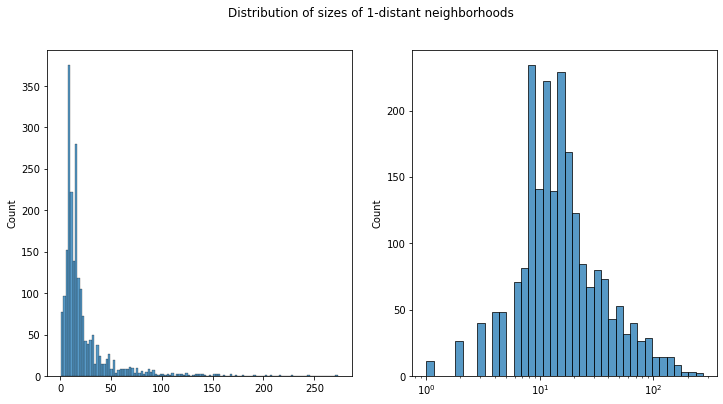

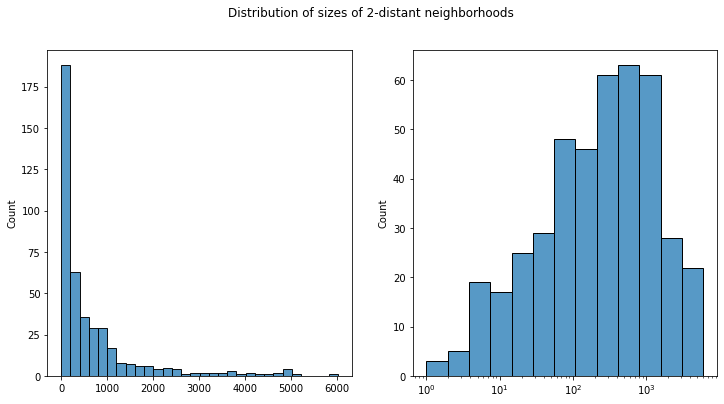

In [104]:
def plot_sizes_k_distant_neigberhoods(gw, k, used_nodes_num=-1):
    if used_nodes_num == -1: # Use all nodes
        used_nodes = gw.graph_part.nodes
    else:
        used_nodes = random.sample(gw.graph_part.nodes, used_nodes_num)
    
    sizes = np.array([len(gw.k_neighborhood(node, k)) for node in used_nodes])
    sizes = sizes[sizes != 0]

    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    sns.histplot(sizes, ax=ax[0])
    sns.histplot(sizes, log_scale=True, ax=ax[1])
    fig.suptitle(f'Distribution of sizes of {k}-distant neighborhoods', fontsize=12)


# To reduce time, we check only part of nodes, (chosen randomly to preserve distribution shape)
plot_sizes_k_distant_neigberhoods(gw, 1, 10000)
plot_sizes_k_distant_neigberhoods(gw, 2, 2000)


We see, that size of 2-distant neighborhoods reach few thousand. These sizes grow exponentially with k. For practical reasons, we decided to operate later on a **value k set to 2**. Higher values would be impractical, both because of computation time, but also because with higher k these neighborhoods become extremely similar for different actors. Lower values also would be impractical, as every time window move would reform one's neighborhood greatly (a new movie would change it more drastically).

In [105]:
K = 2

Now we would like to check how much does the 2-distant neighborhood change for a given actor with every step (1 year move) of time window. We expect these changes to differ depending on how big the actor's neighborhood is. For that reason, we will inspect the changes separately for actors having less than 50 2-distant neighbors, between 50 and 500, and over 500. To measure the change we will use Jaccard similarity coefficient.

In [112]:
def jaccard_coefficient(set1, set2):
    if not set1 and not set2:
        return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

def get_samples(gw, threshold1=50, threshold2=500, n=2000):
    ''' 
        Draw 'n' random actors, split them into three groups 
        according to size of K-distant neighberhood
    '''
    used_nodes = random.sample(gw.graph_part.nodes, n)
    
    gr1 = set()
    gr2 = set()
    gr3 = set()

    for node in used_nodes:
        neighborhood_size = len(gw.k_neighborhood(node, K))
        if neighborhood_size == 0:
            continue # We never want to use actors that didn't play in any movie
        elif neighborhood_size < threshold1:
            gr1.add(node)
        elif neighborhood_size < threshold2:
            gr2.add(node)
        else:
            gr3.add(node)
    return gr1, gr2, gr3

def get_jc_across_time(gw, nodes, tw_start, tw_length, steps_num):
    gw.focus_on_tw(tw_start, tw_length)
    old_neighborhoods = gw.k_neighborhoods(nodes, K)

    coeffs = []
    for _ in tqdm(range(steps_num), total=steps_num):
        gw.move_tw()
        new_neighborhoods = gw.k_neighborhoods(nodes, K)
        step_coeffs = [jaccard_coefficient(new_neighborhoods[node], old_neighborhoods[node]) for node in nodes]
        coeffs.append(mean(step_coeffs))
        old_neighborhoods = new_neighborhoods
    return coeffs

def plot_jc_for_different_tw(gw, nodes, tw_start, tw_length_min=3, tw_length_max=7, steps_num=5):


n = 5000
gr1, gr2, gr3 = get_samples(gw, n=n)
print(f'Split {n} nodes into groups, group 1 size: {len(gr1)}, group 2 size: {len(gr2)}, group 3 size: {len(gr3)}')


print(plot_jaccard_coefficient_across_time(gw, gr1, 1995, 6, 5))
print(plot_jaccard_coefficient_across_time(gw, gr1, 1995, 3, 5))


Split 5000 nodes into groups, group 1 size: 351, group 2 size: 610, group 3 size: 761


A Jupyter Widget

[0.32468842694244837, 0.37328519549961836, 0.46468744997982897, 0.5877392033171364, 0.7149180261958978]
None


A Jupyter Widget

[0.11517659295437073, 0.16170860212728166, 0.22503137887753272, 0.32468842694244837, 0.37328519549961836]
None


In [ ]:
PATRIC_BATEMAN =    'Christian Bale'    # American Psycho (2000)
TYLER_DURDEN =      'Brad Pitt'         # Fight Club (1999)
FRED =              'Cezary Pazura'     # Chłopaki nie płaczą (2000) (polish movie)

# What is the typical k-distant neighborhood size of graph for years 1998 to 2003 for given k




SyntaxError: invalid syntax (<ipython-input-22-019dc04d4d85>, line 7)